# Создание данных измерений с шумом.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
from scipy import interpolate

%matplotlib inline
plt.rc('font', size=16)



Имеется ряд последовательных измерений функции $p(t)$. Требуется максимально точно вычислить $p'(t)$.
В качестве примера рассмотрим
$$
p(t) = \frac{p_0}{1 + \frac{t}{t_0}}.
$$
Добавим к измерениям шум.

In [4]:
t = np.linspace(0, 1000, 1001)
p0 = 200
t0 = 1000

# Смоделируем измерения с погрешностью
p = p0 / (1 + t / t0) + 0.1 * np.random.randn(len(t))

# Истинное значение производной - для сравнения
pprime = -p0 / t0 / (1 + t / t0)**2; 

Text(0, 0.5, 'p')

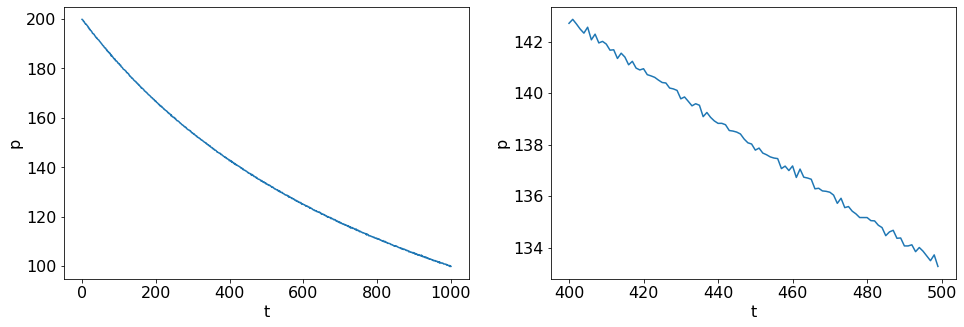

In [5]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t, p)
plt.xlabel('t'); plt.ylabel('p')
plt.subplot(1, 2, 2)
plt.plot(t[400:500], p[400:500])
plt.xlabel('t'); plt.ylabel('p')

#Конечные разности

Простейший способ численно продифференцировать табличную функцию &mdash; вычислить конечную разность.
Рассмотрим две стандартные формулы для вычисления 
$$
p'(t_i) \approx \frac{p(t_{i+1}) - p(t_i)}{t_{i+1} - t_i}\\
p'(t_i) \approx \frac{p(t_{i+1}) - p(t_{i-1})}{t_{i+1} - t_{i-1}}
$$

Отметим, что формулы дифференцирования позволяют найти производную не в каждой точке $t_i$ (кроме некоторых крайних точек). Для дифференцирования в этих точках нужно использовать другие формулы. Сейчас мы не будем на это обращать внимание, просто будем считать производную там, где получится.

In [6]:
def diff1(t, p):
    # Функция np.diff возвращает массив соседних разностей - как раз то, что нужно
    return np.diff(p) / np.diff(t)

def diff2(t, p):
    # Разность через одну точку удобнее считать с помощью операций с частями массива 
    return (p[2:] - p[:-2]) / (t[2:] - t[:-2])

def left_difference (X,Y,x):
  point_index = X.index(x)
  step =X[point_index] - X[point_index - 1]
  first_derivative = (Y[point_index] - Y[point_index - 1])/ step
  second_derivative = (Y[point_index] - 2*Y[point_index - 1] + Y[point_index - 2])/( step ** 2)
  return (first_derivative, second_derivative)

def right_difference (X,Y,x):
  point_index = X.index(x)
  step = X[point_index + 1] - X[point_index]
  first_derivative = (Y[point_index + 1] - Y[point_index])/ step
  second_derivative = (Y[point_index + 2] - 2*Y[point_index + 1] + Y[point_index])/( step ** 2)
  return (first_derivative, second_derivative)

def central_difference (X,Y,x):
  point_index = X.index(x)
  step = X[point_index + 1] - X[point_index]
  first_derivative = (Y[point_index + 1] - Y[point_index - 1])/ (2*step)
  second_derivative = (Y[point_index + 2] - 2*Y[point_index] + Y[point_index - 2])/(4* (step ** 2))
  return (first_derivative, second_derivative)


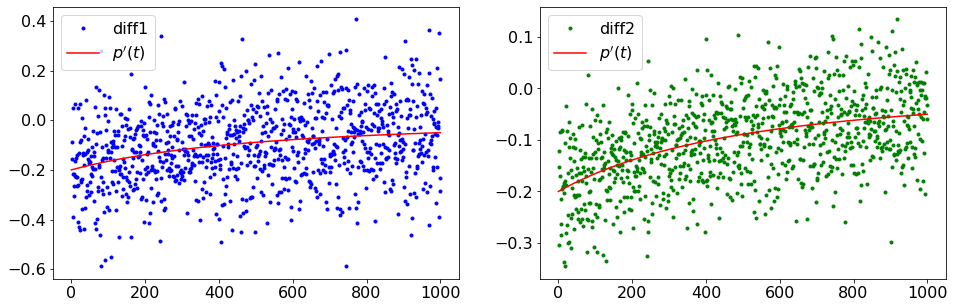

In [7]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t[1:], diff1(t, p), 'b.', label="diff1")
plt.plot(t, pprime, 'r-', label="$p'(t)$")
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(t[1:-1], diff2(t, p), 'g.', label="diff2")
plt.plot(t, pprime, 'r-', label="$p'(t)$")
plt.legend(loc='best')

Видно, что формула второго порядка дает результаты, которые ближе к точному значению. Объясняется ли это тем, что вторая формула имеет второй порядок аппроксимации, а вторая &mdash; лишь первый?

Вспомним, что при численном дифференцировании имеется два источника ошибок &mdash; первая связана с приближенным характером конечной разности (ошибка метода или ошибка аппроксимации), а вторая &mdash; с погрешностью в значениях $p(t_i)$ (ошибка вычислений).

Пусть $\tau = t_{i+1} - t_i$, а $M_k$ &mdash; максимум $k$-й производной функции $p(t)$.

|  Формула для $p'(t_i)$ | Ошибка аппроксимации  | Ошибка вычислений  |
|---|---|---|
| $\frac{p_{i+1} - p_i}{\tau}$  | $\frac{M_2 \tau}{2}$  | $ \frac{2\Delta p}{\tau} $ |
| $\frac{p_{i+1} - p_{i-1}}{2\tau}$  | $\frac{M_3 \tau^2}{6}$  | $\frac{2\Delta p}{2\tau} = \frac{\Delta p}{\tau}$  |

Подставим конкретные значения: $\tau = 1, \Delta p \approx 0.3$ (3 стандартных отклонения). В качестве оценок для максимума возьмем
$$
M_k = \frac{p_0 k!}{t_0^k}
$$
Это значение можно получить из разложения
$$
\frac{p_0}{1 - t/t_0} = 
\sum_{k=0}^\infty (-1)^k \frac{p_0 k!}{t_0^k} \frac{t^k}{k!}
$$

Подставляя эти значения, получаем

|  Формула для $p'(t_i)$ | Ошибка аппроксимации  | Ошибка вычислений  |
|---|---|---|
| $\frac{p_{i+1} - p_i}{\tau}$  | $2\cdot 10^{-4}$  | $0.6$ |
| $\frac{p_{i+1} - p_{i-1}}{2\tau}$  | $2\cdot 10^{-7}$  | $0.3$  |

В данном случае погрешность, связанная с неточным заданием $p(t_i)$, на много порядков превосходит погрешность метода. Как же уменьшить эту ошибку? Достаточно взять две более удаленные точки, например
$$
p'(x_i) \approx \frac{p(t_{i+10}) - p(t_{i-10})}{t_{i+10} - t_{i-10}}
$$

|  Формула для $p'(t_i)$ | Ошибка аппроксимации  | Ошибка вычислений  |
|---|---|---|
| $\frac{p_{i+10} - p_{i-10}}{20\tau}$  | $\frac{M_3 (10\tau)^2}{6} \approx 2 \cdot 10^{-5}$  | $\frac{2\Delta p}{20\tau} = \frac{\Delta p}{10\tau} \approx 0.03$  |

In [8]:
def diff20(t, p):
    return (p[20:] - p[:-20]) / (t[20:] - t[:-20])

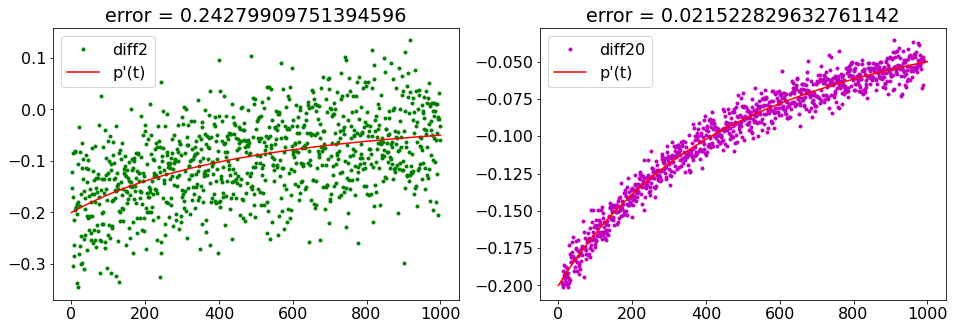

In [9]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t[1:-1], diff2(t, p), 'g.', label="diff2")
plt.plot(t, pprime, 'r-', label="p'(t)")
plt.title('error = ' + str(np.abs(diff2(t, p) - pprime[1:-1]).max()))
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.plot(t[10:-10], diff20(t, p), 'm.', label="diff20")
plt.plot(t, pprime, 'r-', label="p'(t)")
plt.title('error = ' + str(np.abs(diff20(t, p) - pprime[10:-10]).max()))
plt.legend(loc='best')

Видно, что расстояние в 20 точек сработало гораздо лучше расстояния в 2 точки. Но оптимально ли это число?

## Задание 1.



Теоретически найти оптимальное расстояние (имеющее минимальную оценку для суммарной ошибки) между точками, используемыми для вычисления производной. Сравнить фактическую ошибку с теоретической оценкой.
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#


$$p(t) = \frac{p_0}{1+\frac{t}{t_0}} ,\;\; p_0 = 200 ,\;\; t_0 = 1000,\;\; \Delta p = 0.3 $$
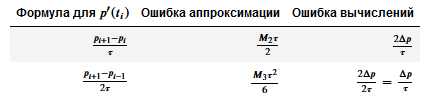
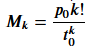
.
$$\Rightarrow \Delta_1 = \frac{M_3 \cdot \tau^2}{6}; \;\;\; \Delta_2 = \frac{\Delta p}{\tau}$$
.
$$\Delta = \Delta_1 + \Delta_2 \rightarrow \mathrm{min}$$
.
$$\partial_{\tau}\Delta = 0$$
.
$$\partial_{\tau}\left(\frac{M_3 \cdot \tau^2}{6}+\frac{\Delta p}{\tau}\right) = \frac{M_3 \cdot \tau}{3}-\frac{\Delta p}{\tau^2} = 0$$
.
$$\tau = \left(\frac{3\Delta p}{M_3}\right)^{1/3} = \left(\frac{3\Delta p\cdot t_0^3}{6p_0}\right)^{1/3} = t_0\cdot\left(\frac{\Delta p}{2p_0}\right)^{1/3}$$
.
$$\boxed{\tau = t_0\cdot\left(\frac{\Delta p}{2p_0}\right)^{1/3} \approx 93}$$
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

In [10]:
1000*(0.3/(2*200))**(0.33)

93.0615361161706

# Сглаживание данных



Несколько другой подход к данной задаче заключается в предварительной очистке данных от шума. Для этого можно попытаться описать данные какой-либо простой зависимостью, а параметры зависимости подогнать по методу наименьших квадратов. Для этого служит функция **np.polyfit**, которая приближает данные многочленом заданной небольшой степени.

In [11]:
# Подогнать данные (t_i, p_i) многочленом пятой степени
# full=True дает доступ к расширенной информации - ошибке приближения
# *_ - отбрасывает все лишние результаты, после первых двух
coeff, [err], *_ =  np.polyfit(t, p, 5, full=True)

Чтобы вычислить полученный многочлен в заданной точке (точках) можно использовать
**np.polyval**

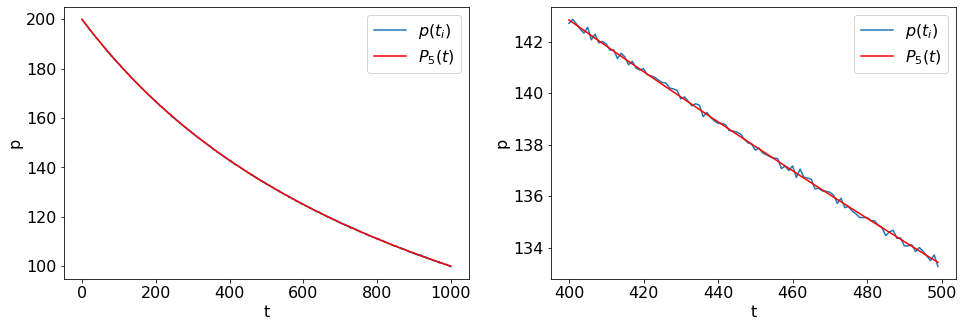

In [12]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t, p, label='$p(t_i)$')
plt.plot(t, np.polyval(coeff, t), 'r-', label='$P_5(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');
plt.subplot(1, 2, 2)
plt.plot(t[400:500], p[400:500], label='$p(t_i)$')
plt.plot(t[400:500], np.polyval(coeff, t[400:500]), 'r-', label='$P_5(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');

Как же определить оптимальный порядок аппроксимирующего многочлена? Слишком маленький порядок не сможет хорошо приблизить данные, а слишком большой будет приближать данные вместе с шумом. В машинном обучении эта проблема назвается компромиссом между сдвигом и дисперсией (bias-variance tradeoff). Переход между данной границей хорошо заметен на графике ошибки в зависимости от степени многочлена. 

Text(0, 0.5, '$\\sum r_i^2$')

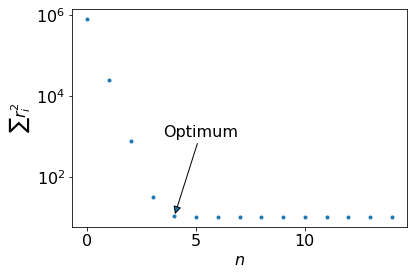

In [13]:
degs = list(range(0, 15))
errs = []
for deg in degs:
    # Сейчас нас интересует только ошибка приближения
    _, [err], *_ =  np.polyfit(t, p, deg, full=True)
    errs.append(err)
    
plt.semilogy(degs, errs, '.')
plt.annotate("Optimum", xy=(degs[4], errs[4]), xytext=(3.5, 1e3), 
             arrowprops={"arrowstyle":"-|>"})
plt.xlabel('$n$')
plt.ylabel('$\sum r_i^2$')

Итак, оптимальная степень многочлена &mdash; 4. В этот раз для вычисления многочлена превратим набор коэффициентов в объект **np.poly1d**.

In [14]:
P4_coeff = np.polyfit(t, p, deg=4) # Получаем с помощью polyfit коэффициенты
P4 = np.poly1d(P4_coeff)           # Превращаем в poly1d
P4der = P4.deriv(m=1)              # poly1d умеет вычислять свои производные

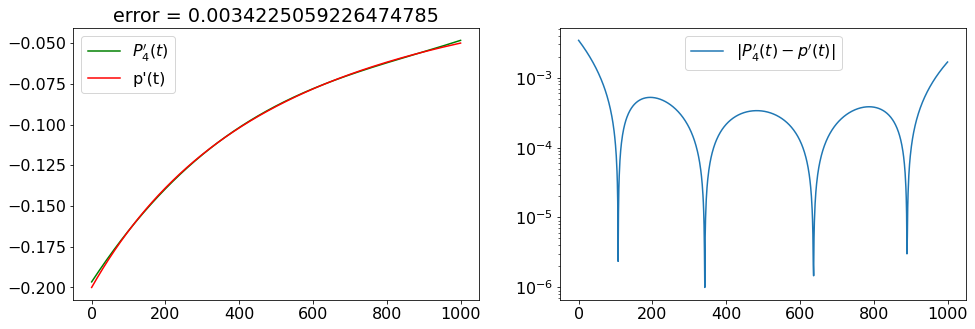

In [15]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t, P4der(t), 'g-', label="$P_4'(t)$")
plt.plot(t, pprime, 'r-', label="p'(t)")
plt.title('error = ' + str(np.abs(P4der(t) - pprime).max()))
plt.legend(loc='best')
plt.subplot(1, 2, 2)
plt.semilogy(t, np.abs(P4der(t) - pprime), label="$|P_4'(t) - p'(t)|$")
plt.legend(loc='best')

# Сглаживание сплайном


Не всегда даже гладкие данные могут быть хорошо описаны многочленом. Особенно плохо приближаются осциллирующие данные. В этом случае приближение многочленом может быть заменено на приближение сплайном.

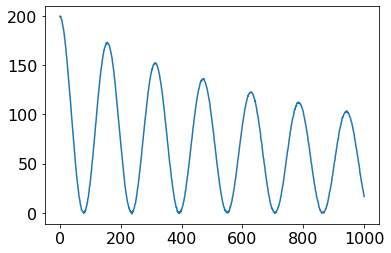

In [16]:
w0 = 0.04
u = p0 / (1 + t/t0) * (0.5 + 0.5 * np.cos(w0 * t)) + 0.5 * np.random.randn(len(t))
uprime = -p0*t0*(1 + np.cos(w0*t) + (t+t0)*w0*np.sin(w0*t))/(2*(t+t0)**2)

plt.plot(t, u)

Попробуем снова приближать многочленами разных степеней. В этом случае характерного излома не наблюдается.

Text(0, 0.5, '$\\sum r_i^2$')

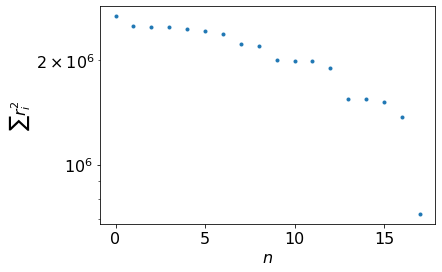

In [17]:
degs = list(range(0, 18))
errs = []
for deg in degs:
    _, [err], *_ =  np.polyfit(t, u, deg, full=True)
    errs.append(err)
    
plt.semilogy(degs, errs, '.')
plt.xlabel('$n$')
plt.ylabel('$\sum r_i^2$')

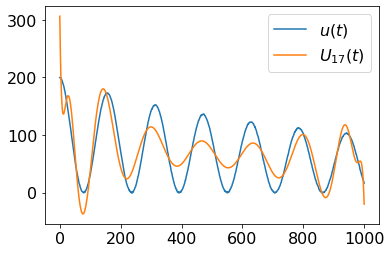

In [18]:
U17 = np.poly1d(np.polyfit(t, u, deg=17))
plt.plot(t, u, label='$u(t)$')
plt.plot(t, U17(t), label='$U_{17}(t)$')
plt.legend(loc='best')

Многочлен приближает данные отвратительно. Приблизим данные сплайном. Для этого воспользуемся возможностями библиотеки **scipy**

In [19]:
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

In [20]:
Uint = InterpolatedUnivariateSpline(t, u, k=3)

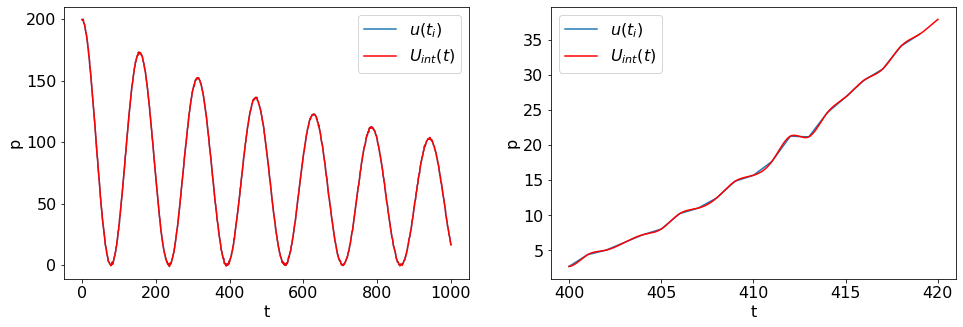

In [21]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t, u, label='$u(t_i)$')
plt.plot(t, Uint(t), 'r-', label='$U_{int}(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');
plt.subplot(1, 2, 2)
plt.plot(t[400:420], u[400:420], label='$u(t_i)$')

tt = np.linspace(t[400], t[420], 500) # Для отрисовки сплайна нужно больше точек

plt.plot(tt, Uint(tt), 'r-', label='$U_{int}(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');

Text(0.5, 1.0, 'error = 1.8894896888748036')

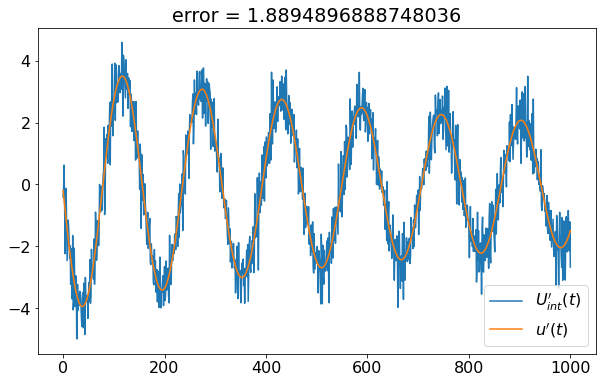

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(t, Uint.derivative()(t), label="$U_{int}'(t)$")
plt.plot(t, uprime, label="$u'(t)$")
plt.legend(loc='best')
plt.title('error = ' + str(np.abs(uprime - Uint.derivative()(t)).max()))

Интерполирующий сплайн повторяет все отклонения исходной функции из-за шума, но сам является гладкой функцией. Для того чтобы действительно сгладить данные, нужно использовать **UnivariateSpline**

In [23]:
# Параметр s отвечает за сглаживание
Usmooth = UnivariateSpline(t, u, s=100)

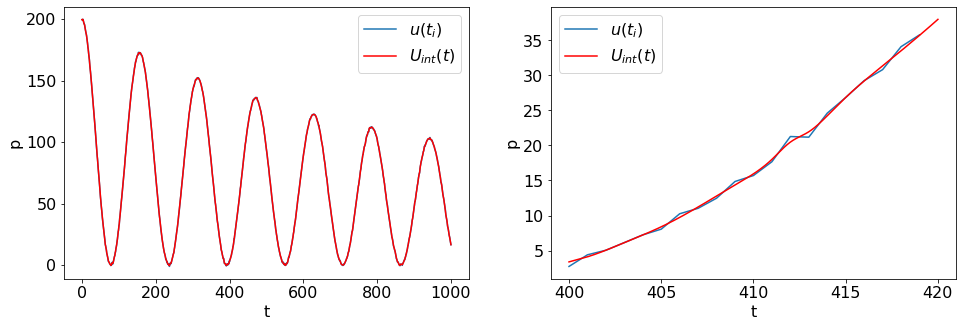

In [24]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(t, u, label='$u(t_i)$')
plt.plot(t, Usmooth(t), 'r-', label='$U_{int}(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');
plt.subplot(1, 2, 2)
plt.plot(t[400:420], u[400:420], label='$u(t_i)$')

tt = np.linspace(t[400], t[420], 500) # Для отрисовки сплайна нужно больше точек

plt.plot(tt, Usmooth(tt), 'r-', label='$U_{int}(t)$')
plt.xlabel('t'); plt.ylabel('p'); plt.legend(loc='best');

Text(0.5, 1.0, 'error = 1.8859231053630083')

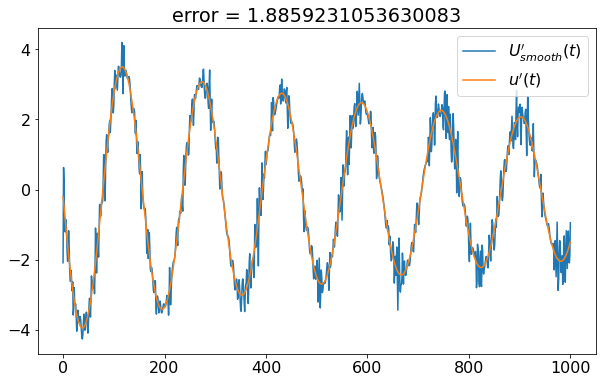

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(t, Usmooth.derivative()(t), label="$U_{smooth}'(t)$")
plt.plot(t, uprime, label="$u'(t)$")
plt.legend(loc='best')
plt.title('error = ' + str(np.abs(uprime - Usmooth.derivative()(t)).max()))

## Задание 2. 



Прочитать документацию к [UnivariateSpline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html) и определить оптимальное значение для параметра сглаживания **s**, учитывая, что шум был задан в виде $u_i = \dots + 0.5 \xi_i, \quad \xi_i \sim \mathcal N(0, 1)$. Экспериментально проверить оптимальность этого значения.
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#
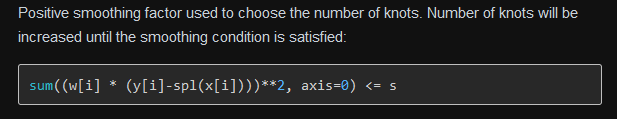
.
$$w_i = 1$$
Легко видеть что эта сумма = суммарная ошибка приближения
$$ \Delta := \sum_i \sigma^2 = N\cdot \sigma^2$$
.
$$y_i = \mathrm{spl}[x_i]+ \frac{1}{2}\xi_i;\;\; \xi_i \sim \mathcal{N}(0,1) $$
.
$$\Rightarrow \Delta = \frac{N}{4}$$
.
$$\boxed{s \approx \frac{N}{4} = 250} $$



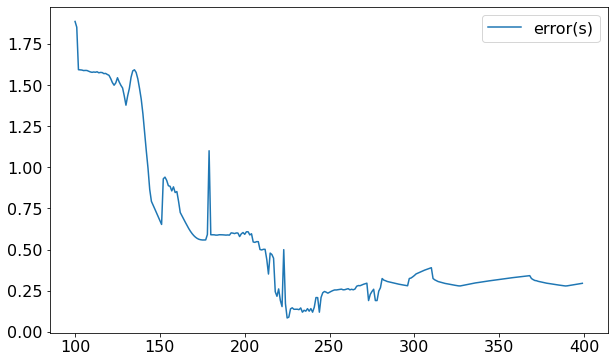

In [26]:
errors = []
x_err = []
for si in range(100, 400):
    Usmooth = UnivariateSpline(t, u, s=si)
    errors = np.append(errors, np.abs(uprime - Usmooth.derivative()(t)).max())
    x_err = np.append(x_err, si)


plt.figure(figsize=(10, 6))
plt.plot(x_err, errors, label="error(s)")
plt.legend(loc='best')

### Видно что оценка хорошая 

# Задание 3.

При дифференцировании функций имеются два основных источника погрешности

- Ошибка метода - уменьшается при уменьшении $\boldsymbol{h}$

- Ошибка вычислений - растет при уменьшении $\boldsymbol{h}$


Поскольку характер роста ошибок различный, существует некоторое значение $h^{*}$, при котором ошибка минимальна. Рассмотрите полную ошибку
$\varepsilon_{\text {total }}=\varepsilon_{\text {method }}+\varepsilon_{\text {comp }}$
как функцию от $h$ для формулы центральной разности и найдите минимум. 

$$
f^{\prime}\left(x_{0}\right) \approx \frac{1}{12 h}\left(f_{i-2}-8 f_{i-1}+8 f_{i+1}-f_{i+2}\right)
$$


Максимум модуля пятой  производной в окрестности $x_{0}$ оценивайте как $M_{5}$, ошибку вычисления $f$ как $\Delta f$.


$$f(x_0+h) = f^{(0)}(x_0) + f^{(1)}(x_0) \cdot h + f^{(2)}(x_0) \cdot \frac{h^2}{2} + f^{(3)}(x_0) \cdot \frac{h^3}{6} + f^{(4)}(x_0) \cdot \frac{h^4}{24} + f^{(5)}(x_0) \cdot \frac{h^5}{120}$$
.
$$f'(x_0) = \frac{1}{12 h}\left(f_{i-2}-8 f_{i-1}+8 f_{i+1}-f_{i+2}\right) = f'(x_0)-f^{(5)}(x_0)\frac{h^4}{30}$$
.
$$\boxed{\Delta_1 = f^{(5)}(x_0)\frac{h^4}{30}}$$
$$f'(x_0) = \frac{1}{12 h}\left(f_{i-2}-8 f_{i-1}+8 f_{i+1}-f_{i+2}\right) \Rightarrow $$
.
$$\Rightarrow \Delta_2 \approx \frac{1}{12h}\left( \Delta f + 8 \Delta f + 8 \Delta f + \Delta f \right) = \boxed{\frac{3 \Delta f}{2 h} = \Delta_2}$$
.
$$\Delta = \Delta_1 + \Delta_2 = f^{(5)}(x_0)\frac{h^4}{30} + \frac{3 \Delta f}{2 h} \rightarrow \mathrm{min}$$
.
$$\frac{3 \Delta f}{2 h^2} = 2 f^{(5)}(x_0)\frac{h^3}{15}$$
.
$$ \boxed{h = \left( \frac{45\Delta f}{2f^{(5)}(x_0)} \right)^{1/5} \approx 20}$$

In [28]:
((45*1.5)/(2*9.8414*(10**(-6))))**(1/5)

20.27885260750564

In [29]:
9.8414*(10**(-6))*(20**4)/30+3*1.5/(2*20)

0.16498746666666667

# Задание 4.

Используя сглаженные данные из задания 2, постройте график производной с помощью формулы из задания 3. Сравнить фактическую ошибку вычисления производной с теоретической оценкой из задания 3. Также сравнить, используя для вычисления производной не соседние точки, а точки на расстоянии, определённом из задания 1.

$$\Delta = f^{(5)}(x_0)\frac{h^4}{30} + \frac{3 \Delta f}{2 h} \approx 0.165$$

In [32]:
h = 20

def derive(t, p):
    return (p[:-4*h] - 8*p[1*h:-3*h] + 8*p[3*h:-1*h] - p[4*h:])/(12*h)

Usmooth = UnivariateSpline(t, u, s=240)

plt.plot(t[2*h:-2*h], diff_from3(t, Usmooth(t)), '.')
plt.plot(t, uprime, label="$u'$")
plt.title('error = ' + str(np.abs(derive(t, Usmooth(t)) - uprime[2*h:-2*h]).max()))
plt.legend(loc='best') 

NameError: name 'diff_from3' is not defined

$$0.05 < 0.17 $$
Это из-за того что мы сгладили данные


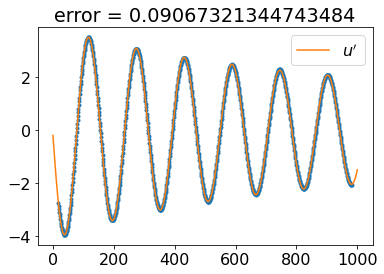

In [74]:
h = 9

def derive(t, p):
    return (p[9:] - p[:-9]) / (t[9:] - t[:-9])

Usmooth = UnivariateSpline(t, u, s=240)

plt.plot(t[2*h:-2*h], diff_from3(t, Usmooth(t)), '.')
plt.plot(t, uprime, label="$u'$")
plt.title('error = ' + str(np.abs(derive(t, Usmooth(t)) - uprime[4:-5]).max()))
plt.legend(loc='best') 

$$0.05 < 0.09 < 0.17 $$
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

# Основы теории погрешностей.


Любая вычисляемая или измеряемая величина определяется с погрешностью. Это значит, что приближённое значение величины, вычисляемое на компьютере, отличается от истинного.

Погрешности бывают абсолютные и относительные. Абсолютная погрешность - это максимальное отклонение от истинного значения, взятое по модулю. Относительная погрешность - вычисленное в процентах.

Погрешности прежде всего разделяют на устранимые и неустранимые. Неустранимыми называют погрешности, вызванные неопределённостью входных данных. Устранимые погрешности бывают двух видов: погрешности округлений при вычислениях на компьютере и погрешности вычислительных методов.

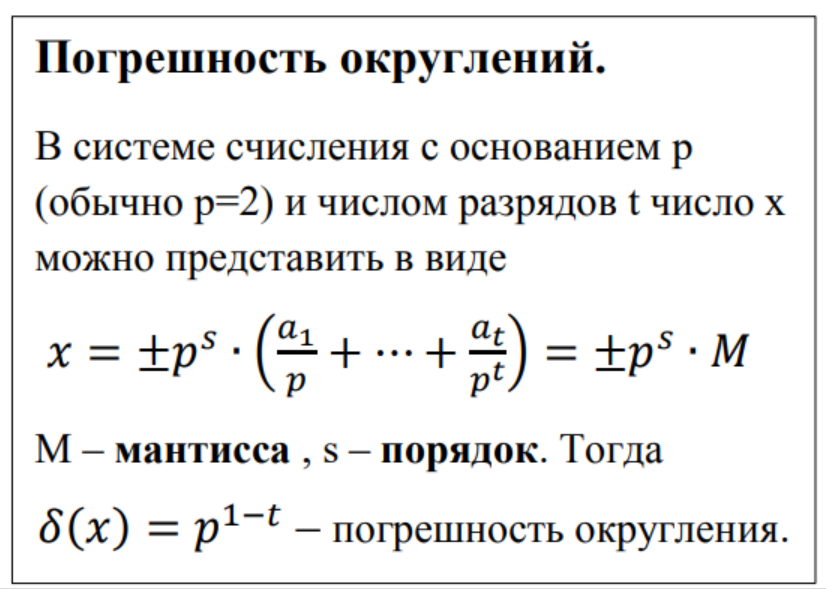


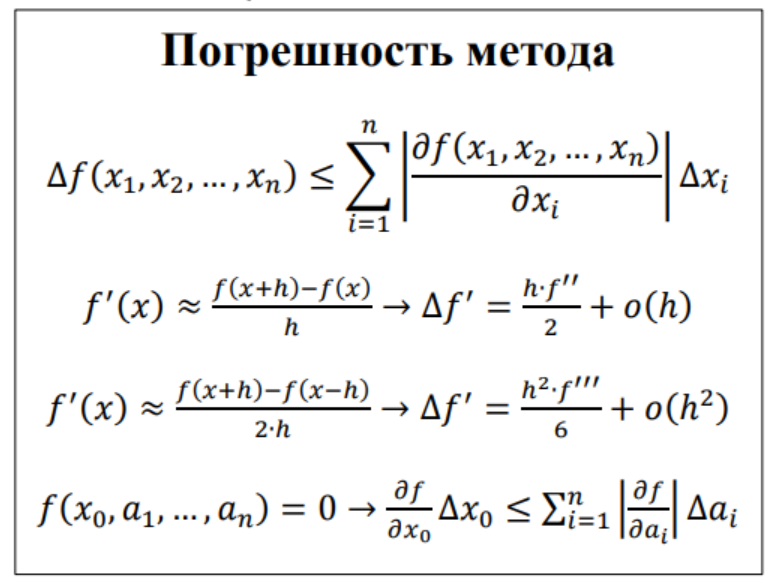

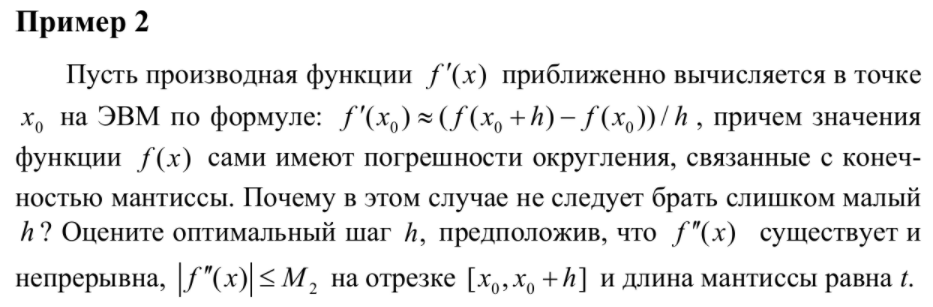

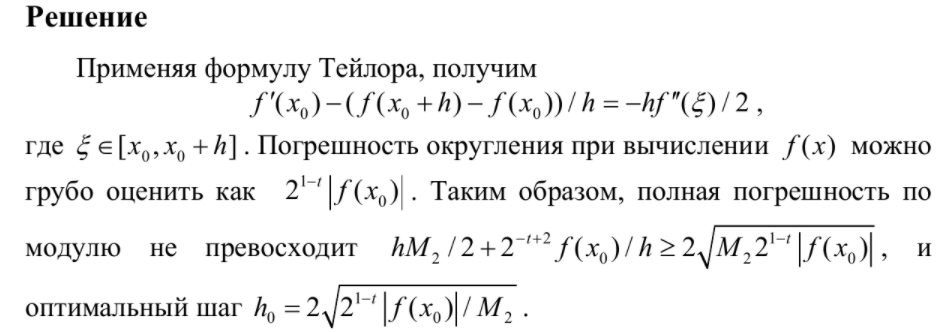

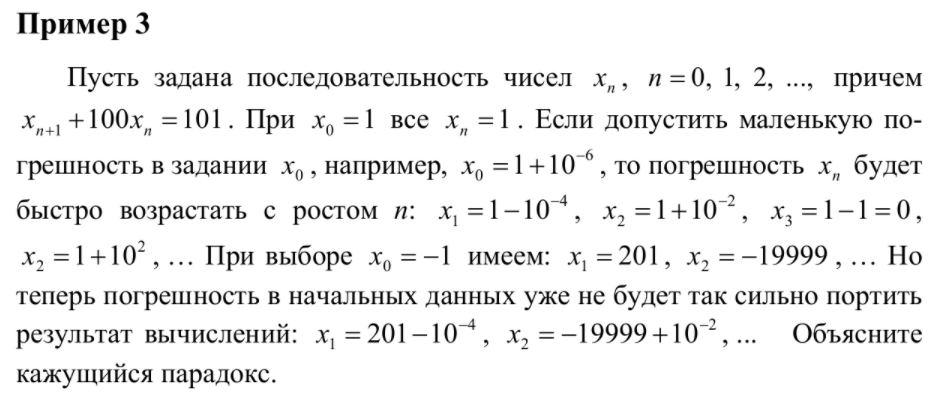

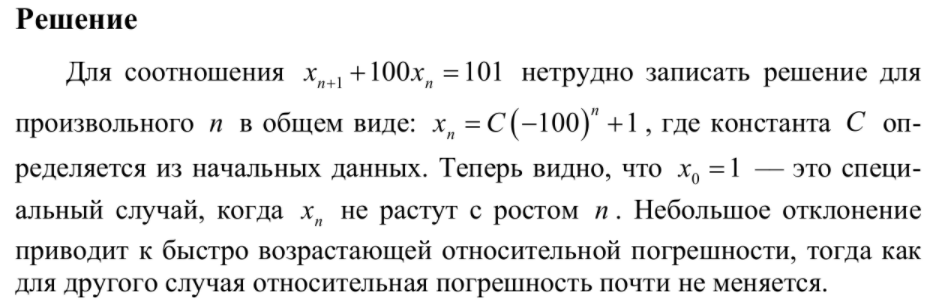

# Задание 5.

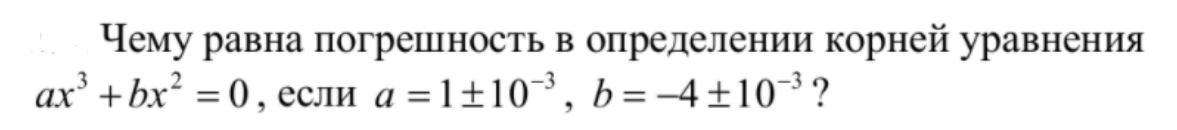

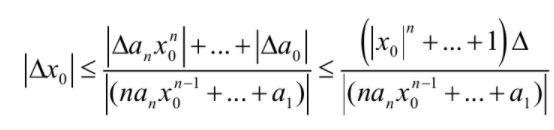


$$|\Delta x_0| \le \frac{\Delta_ax_0^3+\Delta_bx_0^2}{3ax_0^2+2bx_0}$$
.
$$x_0 = 0; \;\;\; x_{00} = -b/a = 4$$
.
$$|\Delta x_0| \le 0$$   
.
$$x_{00} = \frac{0.001\cdot 64 +0.001\cdot 16}{3\cdot1\cdot 16 - 2\cdot4\cdot4} = (4+1)\cdot0.001 = \boxed{0.005}$$

# Задание 6. 

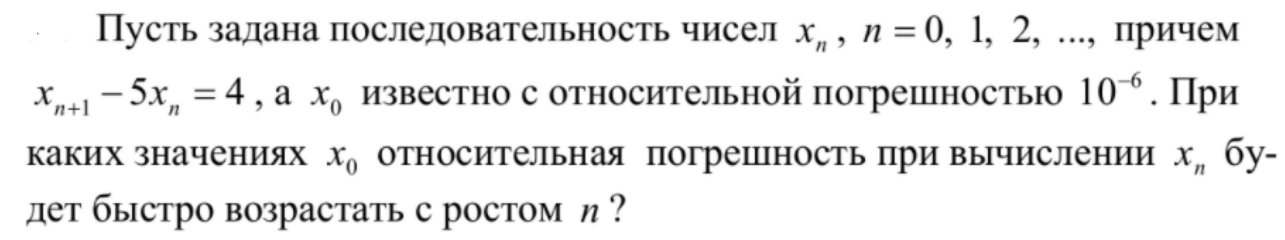

$$x_{n+1} = 5x_n+4 = 5\left( 5x_{n-1}+4 \right)+4 = ... = 5^nx_0 + 4\cdot5^{n-1}+4\cdot5^{n-2}+...4 = 5^nx_0 - 1 + 5^n = 5^n(x_0+1)-1$$
.
$$\Delta x_n = 5^n \Delta x_0 $$
.
$$\varepsilon_{xn} = \Delta x_n/x_n = \frac{\Delta x_0}{x_0+1-5^{-n}} \rightarrow \infty\;\; \mathrm{when}\;\; x_0 \rightarrow -1$$